# Gibbs Sampler para los modelos hard-core y q-coloring


Autores: 
- Daniel Alejandro García Hernández
- David Camilo Cortes Salazar

En este notebook se encuentra una implementación del Gibbs Sampler para Hard-core y q-colorings. 

Las librerías necesarias para ejectuar el código son:

In [1]:
import random
import numpy as np
import networkx as nx
from copy import deepcopy
import matplotlib.pyplot as plt

---
# Punto 3 - Gibbs Sampler para las q-coloraciones (q-colorings)

Iniciamos definiendo algunas funciones que ya habían sido usadas en el programa anterior.


Acto seguido, creamos la grilla del módelo. Para esto, usamos un grafo cuadrado 2D de NetworkX con colores que siguen una diagonal, asegurando así que el estado inicial es una q-coloración válida. 


Este grafo recibe de input las dimensiones $k$ del grafo, y el número $q$ de colores. Se tiene las condiciones:

- $3\leq k \leq 20$,
- $2\leq q \leq 10$.

Los colores ya se encuentran en el código, por lo que no es necesario que el usuario los ingrese.

In [9]:
def restart_G(k, q, colors_list):
    ## Create a lattice, kxk graph
    G = nx.grid_2d_graph(k, k)

    ## Define the positions for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    ## Color of the nodes
    color_values = {node: colors_list[(i + i//k - (i//k)*k)%q] for i, node in enumerate(G.nodes())}
    
    return G, color_values


    
def plot_grid(G, color_values):
    # Define the positions for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    ## Plot the graph
    options = {
        "font_size": 200,
        "node_size": int(30000/k**2),
        "edgecolors": "black",
        "linewidths": 1.7,
        "width": 1.7,
        "with_labels": False,
        "node_color": color_values.values(),
    }

    plt.figure(figsize=(5 + 0.1*k, 5 + 0.1*k))
    nx.draw_networkx(G, pos=pos, **options)
    plt.tight_layout()
    plt.show()
    

    
def find_vecinos_dict():
    vecinos = {}

    for x in range (0, k):
        for y in range (0, k):
            vecinos[(x, y)] = G.neighbors((x,y))
    
    return vecinos


    
def find_valid_colors(G, color_values, x, y):
    colores_vecinos = set()
    
    for vecino in G.neighbors((x,y)):
        colores_vecinos.add(color_values[vecino])
    
    valid_colors = list(set(colors_list) - colores_vecinos)
    
    return valid_colors    
    
    
    
def random_step(G, color_values):
    x = random.choice(range(0,k))
    y = random.choice(range(0,k))
      
    valid_colors = find_valid_colors(G, color_values, x, y)
    new_color = random.choice(valid_colors)
    color_values[(x,y)] = new_color
    
    return color_values
    

    
def find_random_evolution(G, color_values, n):
    for _ in range(n): 
        color_values = random_step(G, color_values)
        
    return color_values
        
        

def systematic_step(G, color_values, x, y):
    valid_colors = find_valid_colors(G, color_values, x, y)
    new_color = random.choice(valid_colors)
    color_values[(x,y)] = new_color
    
    return color_values
    

    
def find_systematic_evolution(G, color_values, n):
    for ii in range(n): 
        x = ii % k
        y = (ii//k) % k
        color_values = systematic_step(G, color_values, x, y)
        
    return color_values
    
    
    
def calculate_number_simulations(epsilon, d=4):
    top = 48 * (d**3) * k**3
    bot = epsilon**2
    return top/bot
    
def calculate_number_gibbs_steps(epsilon, d=4):
    top = 2*np.log(k) + np.log(1/epsilon) + np.log(8)
    bot = np.log(q / (2*d))
    ans = k*(top/bot + 1)
    return ans

In [10]:
print(calculate_number_gibbs_steps(0.5))
print(calculate_number_simulations(0.5))

129.5839330395961
331776.0


Ahora, definimos los inputs del programa

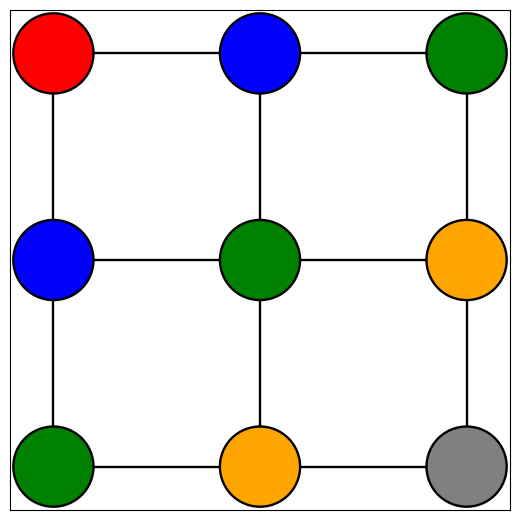

In [4]:
## Inputs del programa    
"""
k: Dimensiones del lattice kxk
q: Numero de colores
d: Maximo numero de vecinos de algun nodo
"""

k = 3
q = 9

## Lista de colores preestablecidos. Se usaran los primeros q
colors_list = ["red", "blue", "green", "orange", "grey", "purple", "black", "magenta", "white", "cyan"]


# Iniciar el valor de los colores
colors_list = colors_list[:q:]
G, color_values = restart_G(k, q, colors_list)
#vecinos = find_vecinos_dict()


# Graficar la grilla
plot_grid(G, color_values)

e_j =  ((1, 0), (1, 1))
Colores de este enlace: black purple
Son iguales?: False
0

G_{j-1}:


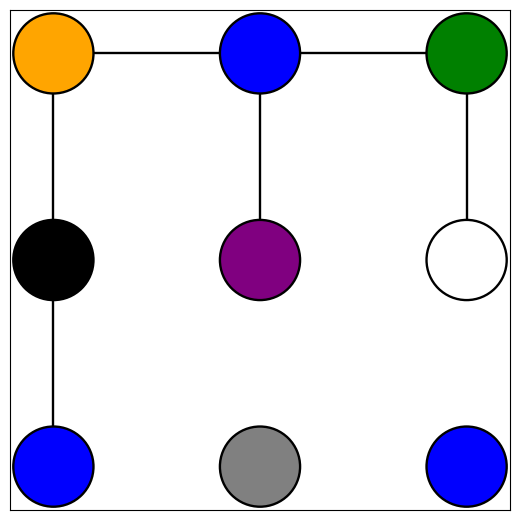




G_{j}:


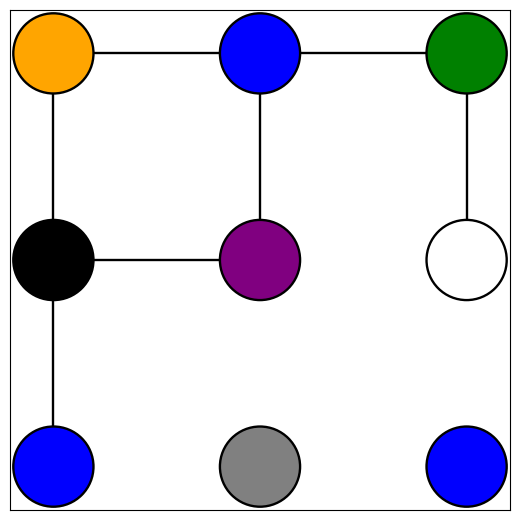

In [15]:
G, color_values = restart_G(k, q, colors_list)

counter_they_are_equal = 0


edges = list(G.edges())

j = 6

edges_to_remove = edges[j : len(edges)]

e_j = edges[j] # Edge which is in G_{j} but not in G_{j−1}

# Find G_{j-1}, graph obtained from G by deleting the edges e_{j}, ... , e_{k}
G_j_1 = deepcopy(G)
for edge_to_remove in edges_to_remove:
    G_j_1.remove_edge(edge_to_remove[0], edge_to_remove[1])


color_values = find_systematic_evolution(G_j_1, color_values, 1)

print('e_j = ',  e_j)
print('Colores de este enlace:', color_values[e_j[0]], color_values[e_j[1]])
print(f'Son iguales?: {color_values[e_j[0]] == color_values[e_j[1]]}')

counter_they_are_equal += int(color_values[e_j[0]] == color_values[e_j[1]])
print(counter_they_are_equal)


print("\nG_{j-1}:")
plot_grid(G_j_1, color_values)


## Verificacion. Grafica de G_j. Sirve para comparar con G_j_1 y ver el indice e_j
G_j = deepcopy(G_j_1)
G_j.add_edge(e_j[0], e_j[1])
print("\n\n\nG_{j}:")
plot_grid(G_j, color_values) 

In [ ]:
n_gibbs_steps = 1000*k*k
n_simulations = 1000

q_colorings = q**(k*k)

G, color_values = restart_G(k, q, colors_list)    
edges = list(G.edges())

for j in range(1, k*k + 1):
    rho_j_1 = 0
    e_j = edges[j] # Edge which is in G_{j} but not in G_{j−1}
    
    edges_to_remove = edges[j : len(edges)]
    for ii in range (n_simulations):
        G, color_values = restart_G(k, q, colors_list)    

        # Find G_{j-1}, graph obtained from G by deleting the edges e_{j}, ... , e_{k}
        G_j_1 = deepcopy(G)
        for edge_to_remove in edges_to_remove:
            G_j_1.remove_edge(edge_to_remove[0], edge_to_remove[1])
            
        color_values = find_systematic_evolution(G_j_1, color_values, n_gibbs_steps)
    
        rho_j_1 += int(color_values[e_j[0]] == color_values[e_j[1]])
    
    rho_j_1 = rho_j_1 / n_simulations
    q_colorings *= rho_j_1

print(q_colorings)